In [1]:
#Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


#Clusterers
from sklearn.cluster import DBSCAN

#Sampling
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid

#For mapper
import gtda.plotting
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection, Eccentricity, Entropy,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)
from mapper_utils import *

#For filter functions and measurements
from sklearn.decomposition import PCA
from scipy.stats import entropy

### This experiment shows using autoencoders as filter functions makes a big difference in the mapper node heterogeneity

#### Reading the data

In [2]:
rs = 1
path = 'MNIST/'
data_ae_full = pd.read_csv(path+'mapper_input_full.csv').drop('Unnamed: 0',axis=1)
data_pca = pd.read_csv(path+'mapper_input_full.csv').drop(['Unnamed: 0', 'P1', 'P2'],axis=1)

In [3]:
data_ae_full

,P1,P2,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0.151289,0.855975,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.635701,0.290369,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.880572,0.726760,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.158464,0.129391,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.224920,0.466948,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.725877,0.279417,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.354007,0.154576,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.444403,0.745394,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.690310,0.560056,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data_pca

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Sampling the data (mapper is computationally expensive, so we run the experiments on a smaller subset of the test data (25%)

In [5]:
X_ae_f,y_ae_f = data_ae_full.drop('label',axis=1), data_ae_full['label']

X_pca,y_pca = data_pca.drop('label',axis=1), data_pca['label']

X_ae_f_s, _, y_ae_f_s, _ = train_test_split(X_ae_f,y_ae_f, train_size = 0.25, \
                                        stratify = y_ae_f, random_state = rs)

X_pca_s, _, y_pca_s, _ = train_test_split(X_pca,y_pca, train_size = 0.25, \
                                          stratify = y_pca, random_state = rs)

In [6]:
all_labels = y_pca.values
all_value, all_counts = np.unique(all_labels, return_counts=True)
all_entropy = entropy(pk = all_counts/len(all_labels))

print('Entropy of the data: ' + str(all_entropy))
print('Counts: ' + str(all_counts))

Entropy of the data: 2.3008483650678215
Counts: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


### Data visualization

#### PCA

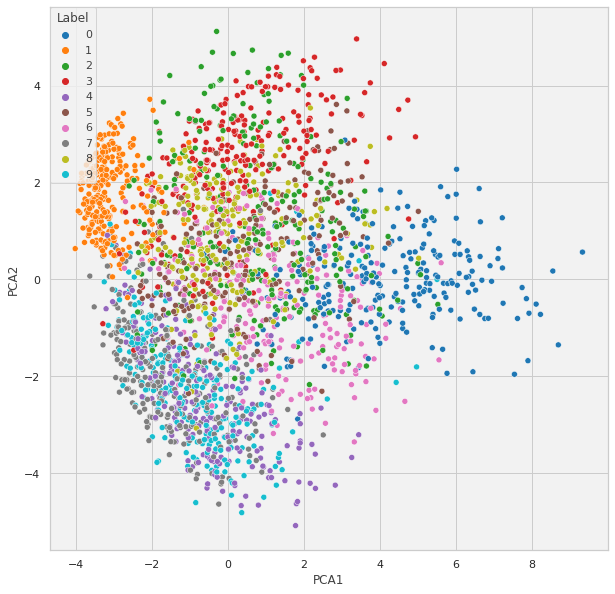

In [285]:
pca = PCA(n_components=2, random_state=rs)
p1 = pca.fit_transform(X_pca_s)
plt.figure(figsize=(10,10))
g = sns.scatterplot(x=p1[:,0], y=p1[:,1], hue=y_pca_s, palette="tab10")
g.set(xlabel='PCA1', ylabel='PCA2')
g.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., title='Label')
plt.savefig(path+'PCA2viz.png', dpi = 300);

#### Autoencoder bottleneck 

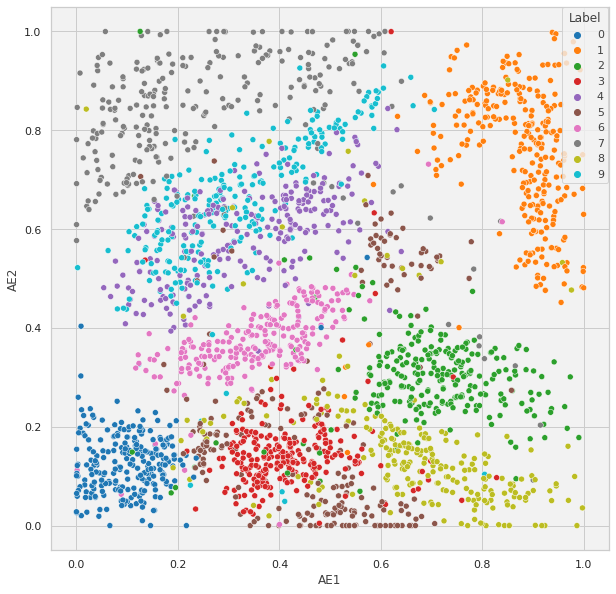

In [286]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(x=X_ae_f_s['P1'], y=X_ae_f_s['P2'], hue=y_ae_f_s, palette='tab10')
g.set(xlabel='AE1', ylabel='AE2')
g.legend(bbox_to_anchor=(0.915, 1), loc=2, borderaxespad=0., title='Label')
plt.savefig(path+'Autoencoderviz.png', dpi = 300)

# Mappers

#### Defining the grid of hyperparamenters. 
PCA vs Autoencoder filters

In [9]:
hyperparams_pca = {'eps': list(np.linspace(0.01,0.5,5)),
               'n_intervals': [int(step) for step in np.linspace(5,25,5)],
               'overlap_frac': list(np.linspace(0.05,0.5,5)),
               'lense': ['pca'],
               'n_components': [2]}



param_grid_pca = ParameterGrid(hyperparams_pca)

In [10]:
Mapper_info_pca = get_mappers(param_grid=param_grid_pca, X_m=X_pca_s, y_m=y_pca_s, rs=rs)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.3s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipel

[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.2s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.8s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   2.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   2.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   3.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   6.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipel

[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipel

In [11]:
hyperparams_ae = {'eps': list(np.linspace(0.01,0.5,5)),
               'n_intervals': [int(step) for step in np.linspace(5,25,5)],
               'overlap_frac': list(np.linspace(0.05,0.5,5)),
               'lense': ['autoencoder'],
               'n_components': [2]}



param_grid_ae = ParameterGrid(hyperparams_ae)

In [12]:
Mapper_info_ae = get_mappers(param_grid=param_grid_ae, X_m=X_ae_f_s, y_m=y_ae_f_s, rs=rs)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.6s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   3.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   4.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.2s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   4.2s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.9s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

In [13]:
Results_pca = Mapper_info_pca[:]
Results_ae = Mapper_info_ae[:]

In [14]:
Results_pca['lense'] = 'PCA'
Results_ae['lense'] = 'Autoencoder'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
Mappers = pd.concat((Results_pca,Results_ae), axis=0)
#Mappers = pd.read_csv(path + 'pca_vs_ae.csv').drop('Unnamed: 0',axis=1)

In [16]:
Mappers

,Epsilon,Number of Intervals,Percentage of Overlap,N Components,Average Node Entropy,Entropy Standard Deviation,Average Node Size,Standard Deviation of Node Size,lense
0,0.01,5,0.0500,2,0.979459,0.603025,124.181818,119.198702,PCA
1,0.01,5,0.1625,2,1.043672,0.613026,154.681818,139.644805,PCA
2,0.01,5,0.2750,2,1.121394,0.595883,191.173913,164.845027,PCA
3,0.01,5,0.3875,2,1.222929,0.574539,251.333333,208.369397,PCA
4,0.01,5,0.5000,2,1.350266,0.511290,336.840000,267.578875,PCA
...,...,...,...,...,...,...,...,...,...
120,0.50,25,0.0500,2,0.258742,0.349316,5.101476,3.982299,Autoencoder
121,0.50,25,0.1625,2,0.296413,0.357624,6.304114,4.866427,Autoencoder
122,0.50,25,0.2750,2,0.337570,0.374343,8.027539,6.152894,Autoencoder
123,0.50,25,0.3875,2,0.390818,0.388609,10.825719,8.087827,Autoencoder


#### Visualizing the results

In [17]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {"axes.facecolor": ".95", 'axes.labelcolor': '.25',\
                          'figure.facecolor': 'white', 'text.color': '.25',\
                           'font.family': ['DejaVu Sans'],})

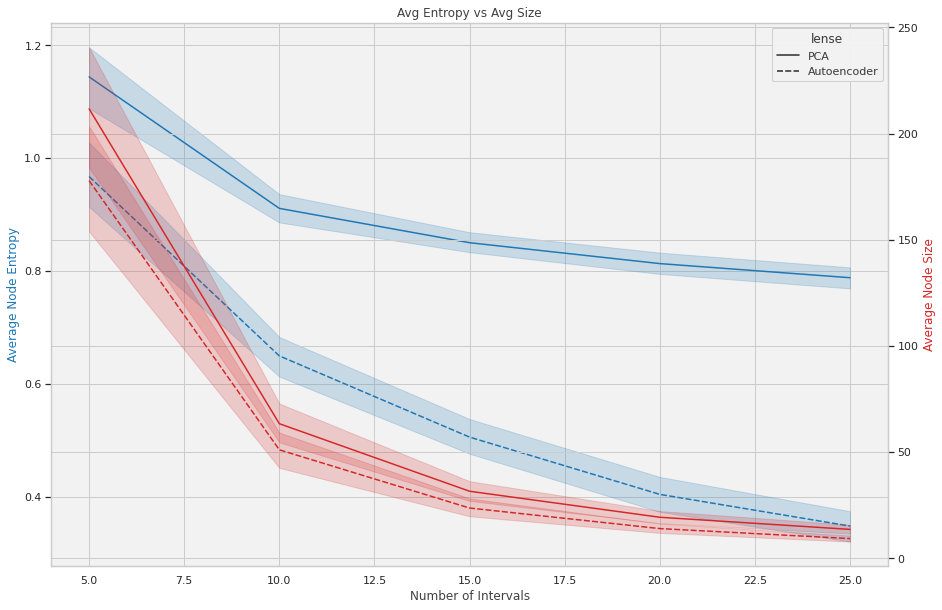

In [18]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Avg Entropy vs Avg Size')
ax1.set_xlabel('Number of Intervals')
ax1.set_ylabel('Average Node Entropy', color = 'tab:blue')
ax2 = sns.lineplot(x='Number of Intervals', y='Average Node Entropy', data = Mappers,\
                color = 'tab:blue', style = 'lense')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Node Size', color = 'tab:red')
ax2 = sns.lineplot(x='Number of Intervals', y='Average Node Size', data = Mappers,\
                   color = 'tab:red', style = 'lense')
ax2.tick_params(axis='y')
plt.show()

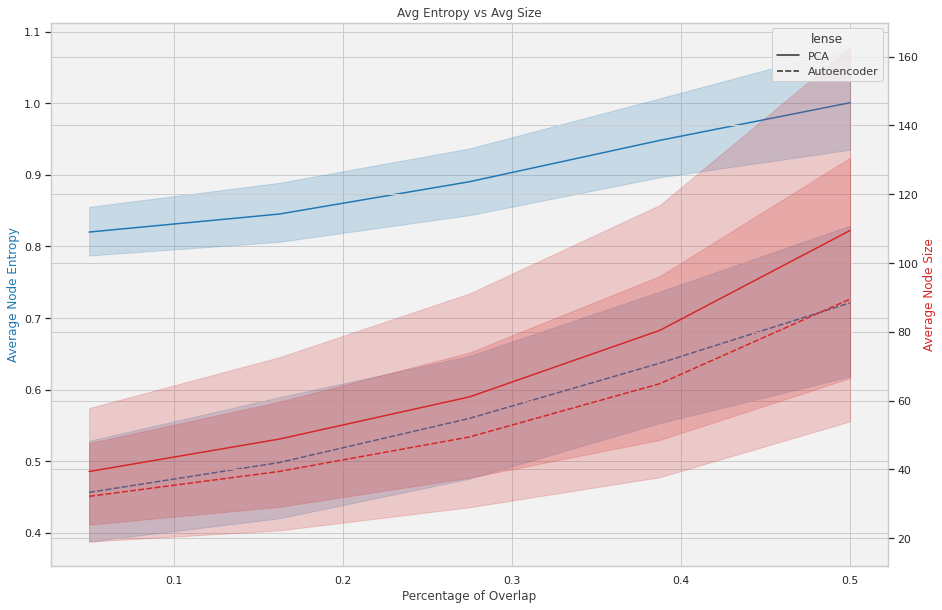

In [19]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Avg Entropy vs Avg Size')
ax1.set_xlabel('Percentage of Overlap')
ax1.set_ylabel('Average Node Entropy', color = 'tab:blue')
ax2 = sns.lineplot(x='Percentage of Overlap', y='Average Node Entropy', data = Mappers,\
                color = 'tab:blue', style = 'lense')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Node Size', color = 'tab:red')
ax2 = sns.lineplot(x='Percentage of Overlap', y='Average Node Size', data = Mappers,\
                   color = 'tab:red', style = 'lense')
ax2.tick_params(axis='y')
plt.show()

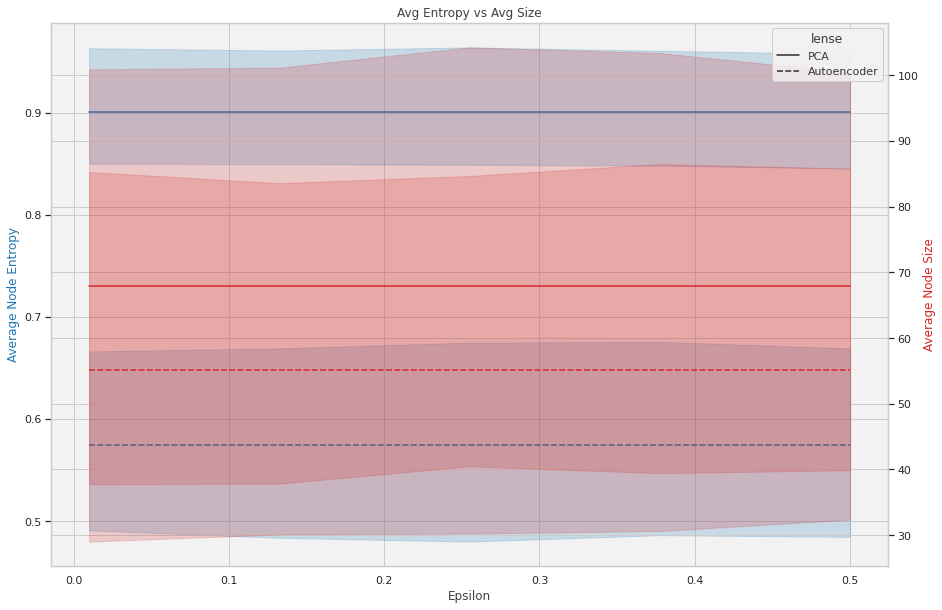

In [20]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Avg Entropy vs Avg Size')
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Average Node Entropy', color = 'tab:blue')
ax2 = sns.lineplot(x='Epsilon', y='Average Node Entropy', data = Mappers,\
                color = 'tab:blue', style = 'lense')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Node Size', color = 'tab:red')
ax2 = sns.lineplot(x='Epsilon', y='Average Node Size', data = Mappers,\
                   color = 'tab:red', style = 'lense')
ax2.tick_params(axis='y')
plt.show()

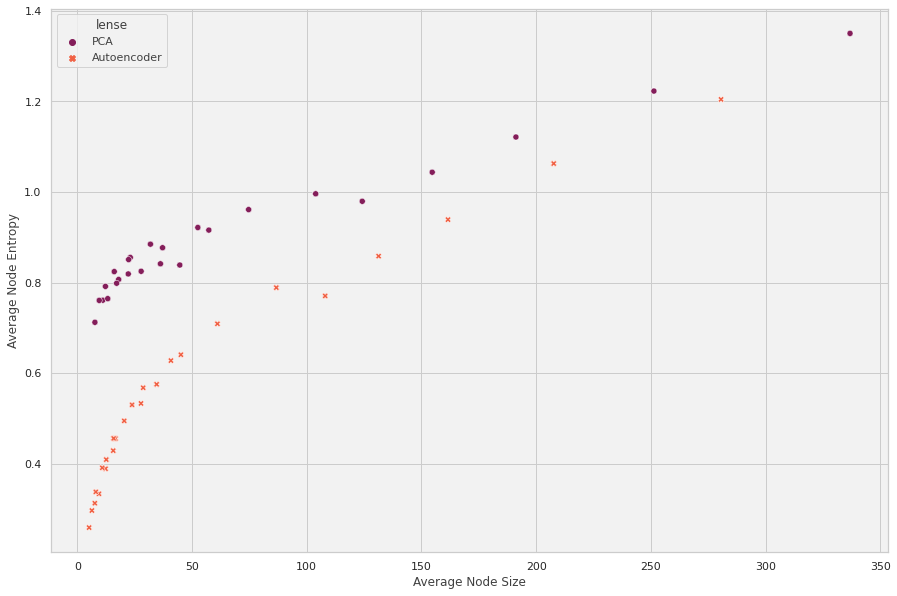

In [21]:
sns.scatterplot(x = "Average Node Size", y = "Average Node Entropy",
                 palette = 'rocket',
                 hue = 'lense',
                 style = 'lense',
                 data = Mappers)
plt.savefig(path+'MNIST_AEvsPCA_results.png',dpi=300)

In [22]:
Mappers

,Epsilon,Number of Intervals,Percentage of Overlap,N Components,Average Node Entropy,Entropy Standard Deviation,Average Node Size,Standard Deviation of Node Size,lense
0,0.01,5,0.0500,2,0.979459,0.603025,124.181818,119.198702,PCA
1,0.01,5,0.1625,2,1.043672,0.613026,154.681818,139.644805,PCA
2,0.01,5,0.2750,2,1.121394,0.595883,191.173913,164.845027,PCA
3,0.01,5,0.3875,2,1.222929,0.574539,251.333333,208.369397,PCA
4,0.01,5,0.5000,2,1.350266,0.511290,336.840000,267.578875,PCA
...,...,...,...,...,...,...,...,...,...
120,0.50,25,0.0500,2,0.258742,0.349316,5.101476,3.982299,Autoencoder
121,0.50,25,0.1625,2,0.296413,0.357624,6.304114,4.866427,Autoencoder
122,0.50,25,0.2750,2,0.337570,0.374343,8.027539,6.152894,Autoencoder
123,0.50,25,0.3875,2,0.390818,0.388609,10.825719,8.087827,Autoencoder


In [23]:
#Mappers.to_csv(path + 'pca_vs_ae.csv')

In [24]:
#Mappers_exp_results = pd.read_csv(path + 'pca_vs_ae.csv') 

#### The following are the selected parameters to build the mapper.

In [267]:
selected_params = {
    'n_intervals': 15,
    'overlap_frac': 0.15,
    'eps': 0.1
}

In [268]:
# Define filter function - can be any scikit-learn transformer
filter_func_pca = PCA(n_components = 2)
# Define cover
cover_pca = CubicalCover(n_intervals=selected_params['n_intervals'], \
                     overlap_frac=selected_params['overlap_frac'])
# Choose clustering algorithm - default is DBSCAN
clusterer_pca = DBSCAN(eps = selected_params['eps'])
#The lower eps is, the higher the density needed to form a cluster

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
selected_pipe_pca = make_mapper_pipeline(
    filter_func=filter_func_pca,
    cover=cover_pca,
    clustering_preprocessing= None, 
    clusterer=clusterer_pca,
    graph_step=True,
    verbose=True,
    n_jobs=n_jobs,
    contract_nodes = False
)

In [269]:
#another nice layout is fruchterman_reingold
fig_pca = plot_interactive_mapper_graph(selected_pipe_pca, X_pca_s, \
                              layout="auto", \
                              color_by_columns_dropdown=False, \
                              color_variable = y_pca_s.values)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


In [270]:
fig_pca

In [271]:
# Define filter function - can be any scikit-learn transformer

filter_func_ae_f = Projection(columns = ['P1', 'P2'])
# Define cover
cover_ae_f = CubicalCover(n_intervals=selected_params['n_intervals'], \
                     overlap_frac=selected_params['overlap_frac'])
# Choose clustering algorithm - default is DBSCAN
clusterer_ae_f = DBSCAN(eps = selected_params['eps'])
#The lower eps is, the higher the density needed to form a cluster

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
selected_pipe_ae_f = make_mapper_pipeline(
    filter_func=filter_func_ae_f,
    cover=cover_ae_f,
    clustering_preprocessing= None, 
    clusterer=clusterer_ae_f,
    graph_step=True,
    verbose=True,
    n_jobs=n_jobs,
    contract_nodes = False
)

In [283]:
fig_ae = plot_interactive_mapper_graph(selected_pipe_ae_f, X_ae_f_s, \
                              layout="auto", \
                              color_by_columns_dropdown=False, \
                              color_variable = y_ae_f_s.values)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s


In [284]:
fig_ae

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.7s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s


### Analysis

In [215]:
#Generate mapper graph and its nodes and observations in each node
graph = selected_pipe_ae_f.fit_transform(X_ae_f_s)
node_elements = graph.vs["node_elements"]
node_ids = graph.vs["pullback_set_label"]
path_compare = path
subg_info = pd.read_csv(path+'test.csv')#.drop('Unnamed: 0',axis=1)
subg_compare = X_ae_f_s.merge(subg_info, how = 'inner', left_index = True, right_index = True)
columns_compare = [col for col in subg_info if 'x' not in col ]
subgroups = subg_compare[columns_compare]
every = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',\
        7:'7',8:'8',9:'9'}

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s


In [232]:
#Select interesting node in the mapper (node id in hovering label)
node_of_interest = 91 # 
#Get columns to reconstruct images
cols = [col for col in X_ae_f_s.columns if 'x' in col]
#Extract the atributes (pixels) of the observations of each node
relevant_info = X_ae_f_s.iloc[node_elements[node_of_interest]][cols]
#Extract label info
sg = subgroups.iloc[node_elements[node_of_interest]]
#Generate info for table visualization
sg['Labels ' + '(' + str(len(sg)) + ' observations)'] = sg['label'].replace(every);
sg['Percentages of ' + 'node ' + str(node_of_interest)] = sg['label']
df = ((sg.groupby('Labels ' + '(' + str(len(sg)) + ' observations)').count()\
       .sort_values(by = 'Percentages of ' + 'node ' + str(node_of_interest), \
    ascending = False)/len(sg))*100)[['Percentages of ' + 'node ' + str(node_of_interest)]]
#df.style.bar(subset = ['Percentage'], color='#7CEC18', axis = 0)
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Percentages of node 91
Labels (104 observations),
3,85.576923
5,4.807692
8,4.807692
2,3.846154
9,0.961538


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



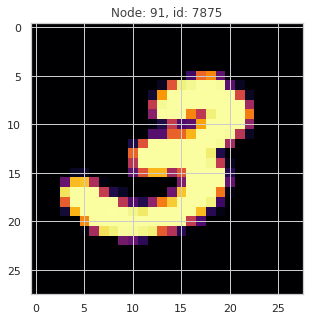

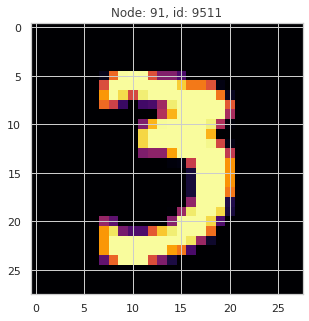

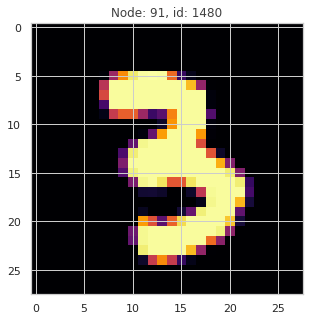

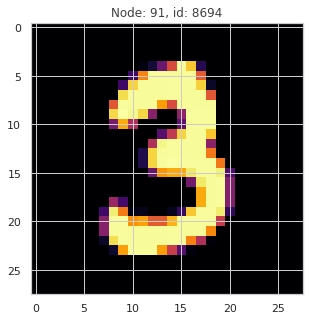

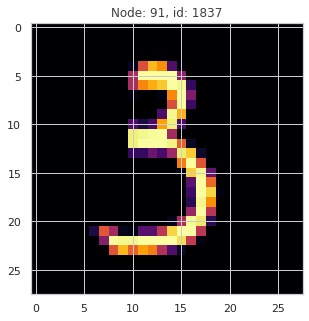

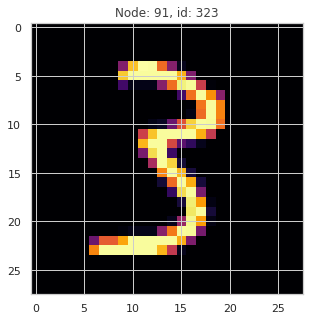

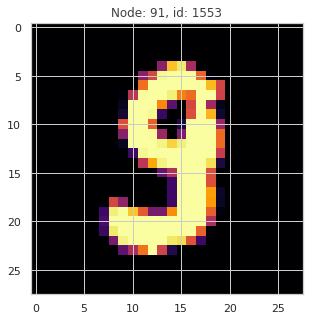

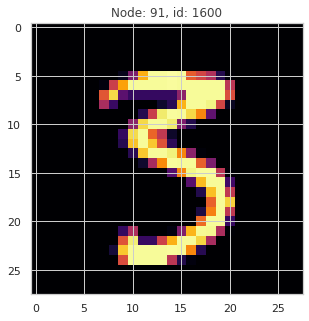

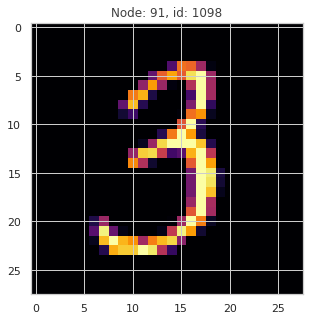

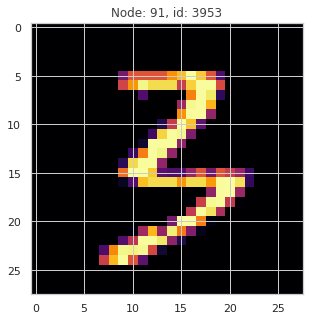

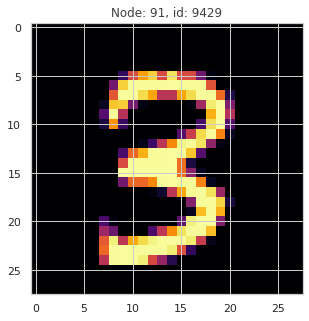

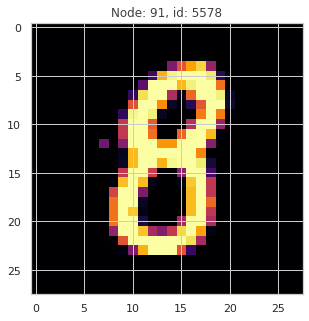

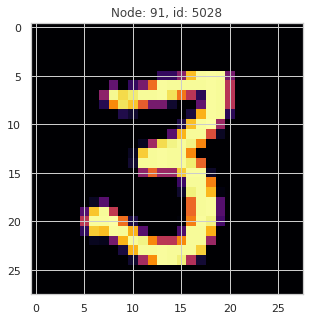

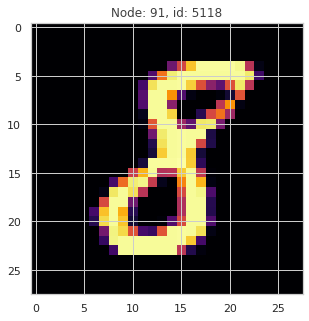

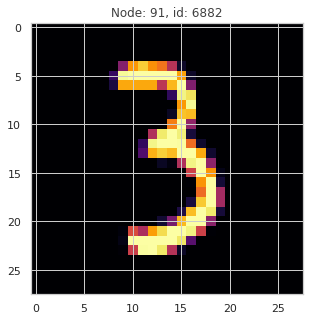

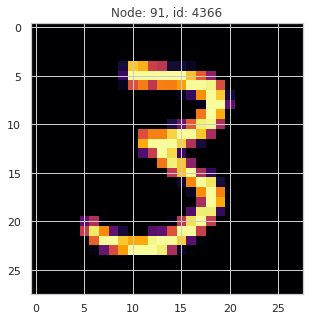

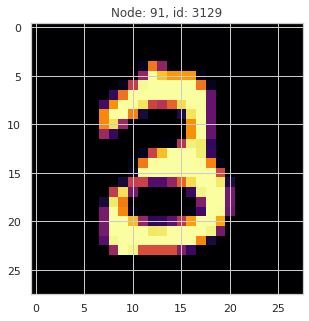

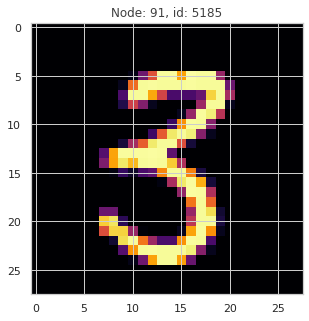

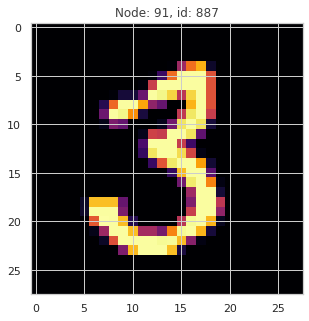

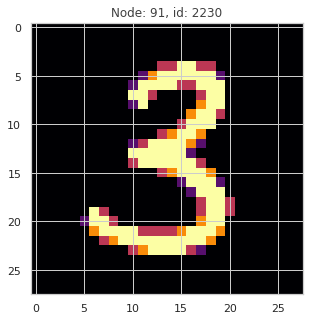

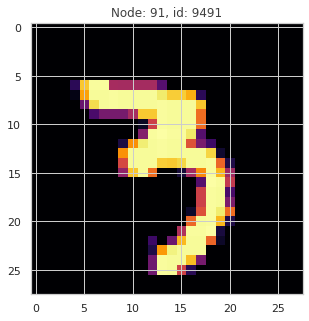

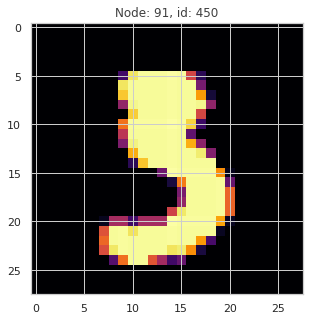

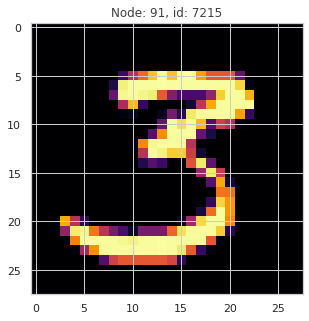

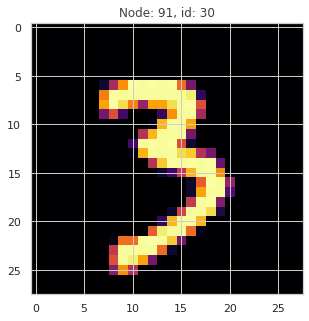

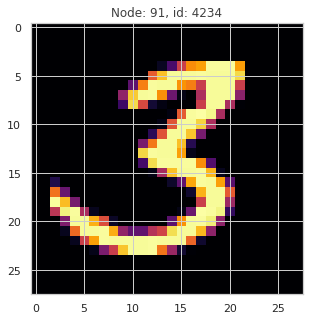

In [233]:
#See the pictures of at most 5 of the observations
i = 0
for idx, row in relevant_info.iterrows():
    i = i+1
    if i <= 25:
        plt.figure(figsize=(5,5))
        plt.title('Node: ' + str(node_of_interest) + ', id: ' + str(idx))
        plt.imshow(row.to_numpy().reshape(28,28), cmap = 'inferno')
        #plt.savefig(path+'sample_images/' + object_label + '.png', dpi=300)

In [ ]:
#Data regarding the labels asigned to each category and subcategory

#0: footwear = {5:'sandal',7:'sneaker',9:'ankle_boot'}
#1: accessories = {8:'bag'}
#2: other = {0:'t-shirt',1:'trouser',2:'pullover',3:'dress',4:'coat',6:'shirt'}
#every = {0:'t-shirt',1:'trouser',2:'pullover',3:'dress',4:'coat',5:'sandal',6:'shirt',\
#         7:'sneaker',8:'bag',9:'ankle_boot'}
#0: footwear, 1:accesories, 2:other 

In [94]:

hyperparams_pca = {'eps': list(np.linspace(0.01,0.5,5)),
               'n_intervals': [int(step) for step in np.linspace(5,25,5)],
               'overlap_frac': list(np.linspace(0.05,0.5,5)),
               'lense': ['pca'],
               'n_components': [2]}



param_grid_pca = ParameterGrid(hyperparams_pca)

In [96]:
hyperparams_pca

{'eps': [0.01, 0.1325, 0.255, 0.3775, 0.5],
 'n_intervals': [5, 10, 15, 20, 25],
 'overlap_frac': [0.05, 0.1625, 0.275, 0.3875, 0.5],
 'lense': ['pca'],
 'n_components': [2]}